In [ ]:
import pandas as pd
import numpy as np
import os
import glob
import random

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Dacon/train/train.csv')
submission = pd.read_csv('/content/drive/MyDrive/Dacon/sample_submission.csv')

In [ ]:
train['Minute'] = train['Minute'].apply(lambda x : x if x == 0 else 0.5)
train['Time'] = train['Hour'] + train['Minute']
train  = train.drop(['Day', 'Minute', 'Hour'], axis=1)

In [ ]:
train['TARGET1'] = train['TARGET'].shift(48)
train['TARGET2'] = train['TARGET'].shift(96)

In [ ]:
temp = train.copy()

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
X_MinMax_train = min_max_scaler.fit_transform(train)

train = pd.DataFrame(X_MinMax_train, columns=train.columns, index=list(train.index.values))

train['TARGET1'] = temp['TARGET1']
train['TARGET2'] = temp['TARGET2']

In [ ]:
from sklearn.model_selection import train_test_split

df_train_1 = train.iloc[48:, :]
df_train_2 = train.iloc[96:, :]
# Y_train_1 = Target1
# Y_train_2 = Target2(Target2 = 1일 앞으로 댕겼음)
x_train_1 = df_train_1.iloc[:35008, :-2]
y_train_1 = df_train_1.iloc[:35008, -2]

x_train_2 = df_train_2.iloc[:34976, :-2]
y_train_2 = df_train_2.iloc[:34976, -2]

x_valid_1 = df_train_1.iloc[35008:, :-2]
y_valid_1 = df_train_1.iloc[35008:, -2]

x_valid_2 = df_train_2.iloc[34976:, :-2]
y_valid_2 = df_train_2.iloc[34976:, -2]

# MLP

In [ ]:
import tensorflow as tf
from tensorflow.keras.backend import mean, maximum

def quantile_loss(q, y, pred):
  err = (y-pred)
  return mean(maximum(q*err, (q-1)*err), axis=-1)

from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True, patience=5)
quantiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

In [ ]:
def MLP(train_x, train_y, valid_x, valid_y):
  
  MLP_models = []
  MLP_pred = pd.DataFrame()

  for q in quantiles : 
    MLP_model = tf.keras.Sequential([
                                # tf.keras.layers.Dense(units=6, activation='tanh', input_shape=(1,)),
                                tf.keras.layers.Dense(units=48, input_shape=(7, )),
                                tf.keras.layers.Dense(units=24),
                                tf.keras.layers.Dense(units=12),                            
                                tf.keras.layers.Dense(units=1, activation='relu'),
    ])

    MLP_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00007), loss=lambda y,pred: quantile_loss(q,y,pred))
    #MLP_model.summary()

    print("♡♡♡♡♡♡♡♡♡♡♡ q = ", q, " ♡♡♡♡♡♡♡♡♡♡")
    MLP_model.fit(train_x, train_y, epochs=3000, batch_size=35008, validation_data=(valid_x, valid_y), callbacks=[es])
    MLP_models.append(MLP_model)

  return MLP_models

In [ ]:
MLP_model = tf.keras.Sequential([
                              # tf.keras.layers.Dense(units=6, activation='tanh', input_shape=(1,)),
                              tf.keras.layers.Dense(units=48, input_shape=(7, )),
#                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dense(units=24),
                              tf.keras.layers.Dense(units=1, activation='relu'),
    ])
MLP_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0027), loss=lambda y,pred: quantile_loss(0.1,y,pred))
#MLP_model.summary()

MLP_model.fit(x_train_1, y_train_1, epochs=3000, batch_size=35008, validation_data=(x_valid_1, y_valid_1), callbacks=[es])

Epoch 1/2000
1/1 [==============================] - 1s 558ms/step - loss: 1.9399 - val_loss: 1.9273
Epoch 2/2000
1/1 [==============================] - 0s 69ms/step - loss: 1.9370 - val_loss: 1.9244
Epoch 3/2000
1/1 [==============================] - 0s 63ms/step - loss: 1.9342 - val_loss: 1.9215
Epoch 4/2000
1/1 [==============================] - 0s 61ms/step - loss: 1.9313 - val_loss: 1.9186
Epoch 5/2000
1/1 [==============================] - 0s 69ms/step - loss: 1.9284 - val_loss: 1.9158
Epoch 6/2000
1/1 [==============================] - 0s 63ms/step - loss: 1.9255 - val_loss: 1.9129
Epoch 7/2000
1/1 [==============================] - 0s 61ms/step - loss: 1.9226 - val_loss: 1.9101
Epoch 8/2000
1/1 [==============================] - 0s 64ms/step - loss: 1.9197 - val_loss: 1.9072
Epoch 9/2000
1/1 [==============================] - 0s 66ms/step - loss: 1.9169 - val_loss: 1.9043
Epoch 10/2000
1/1 [==============================] - 0s 75ms/step - loss: 1.9140 - val_loss: 1.9015
Epoch 11

In [ ]:
pred = MLP_model.predict(x_train_1)

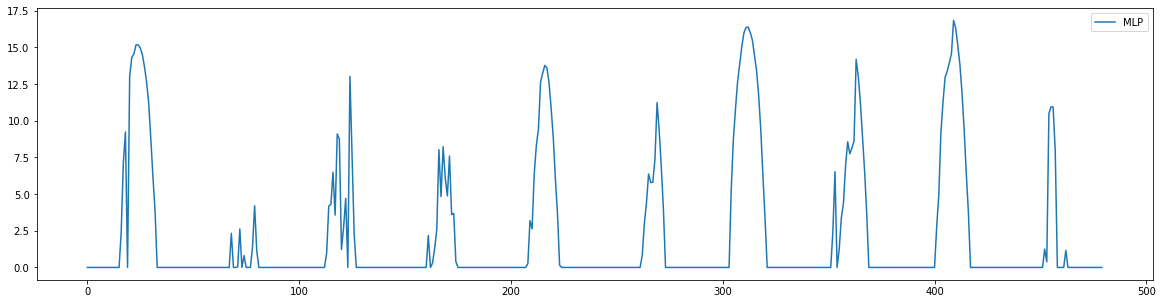

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(pred[:480], label='MLP')
plt.legend()
plt.show()

In [ ]:
MLP_models_1 = MLP(x_train_1, y_train_1, x_valid_1, y_valid_1)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 95ms/step - loss: 12.0646 - val_loss: 12.0034
Epoch 509/3000
1/1 [==============================] - 0s 100ms/step - loss: 12.0564 - val_loss: 11.9952
Epoch 510/3000
1/1 [==============================] - 0s 94ms/step - loss: 12.0481 - val_loss: 11.9871
Epoch 511/3000
1/1 [==============================] - 0s 90ms/step - loss: 12.0398 - val_loss: 11.9789
Epoch 512/3000
1/1 [==============================] - 0s 100ms/step - loss: 12.0315 - val_loss: 11.9707
Epoch 513/3000
1/1 [==============================] - 0s 142ms/step - loss: 12.0232 - val_loss: 11.9625
Epoch 514/3000
1/1 [==============================] - 0s 94ms/step - loss: 12.0149 - val_loss: 11.9543
Epoch 515/3000
1/1 [==============================] - 0s 95ms/step - loss: 12.0065 - val_loss: 11.9460
Epoch 516/3000
1/1 [==============================] - 0s 98ms/step - loss: 11.9981 - val_loss: 11.9377
Epoch 517/3000
1/1 [=============================

In [ ]:
MLP_models_2 = MLP(x_train_2, y_train_2, x_valid_2, y_valid_2)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 501/3000
1/1 [==============================] - 0s 98ms/step - loss: 12.6103 - val_loss: 12.5024
Epoch 502/3000
1/1 [==============================] - 0s 100ms/step - loss: 12.5969 - val_loss: 12.4891
Epoch 503/3000
1/1 [==============================] - 0s 122ms/step - loss: 12.5834 - val_loss: 12.4758
Epoch 504/3000
1/1 [==============================] - 0s 316ms/step - loss: 12.5699 - val_loss: 12.4625
Epoch 505/3000
1/1 [==============================] - 0s 106ms/step - loss: 12.5564 - val_loss: 12.4491
Epoch 506/3000
1/1 [==============================] - 0s 109ms/step - loss: 12.5428 - val_loss: 12.4357
Epoch 507/3000
1/1 [==============================] - 0s 102ms/step - loss: 12.5293 - val_loss: 12.4223
Epoch 508/3000
1/1 [==============================] - 0s 131ms/step - loss: 12.5156 - val_loss: 12.4088
Epoch 509/3000
1/1 [==============================] - 0s 102ms/step - loss: 12.5020 - val_loss: 12.3954
Epoch 510/3000
1/1 [=========

In [ ]:
%matplotlib inline 
for j in range(9):
  predict_result = pd.DataFrame(MLP_models_1[0].predict(x_train_1))
  
  print("★★★★★★★ q = ", j, " ★★★★★★★")
  
  for i in range(10):
    plt.figure(figsize=(20, 5))
    plt.plot(predict_result[480*i:480*(i+1)], label='MLP')
    plt.plot(y_train_1.reset_index().iloc[:, 1:][480*i:480*(i+1)], label='ground_truth')
    plt.legend()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.